In [2]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import data_utils
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# read dataset
X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = data_utils.read_dataset('data.pkl')

In [ ]:
# inspect data
print 'Sentence in English - encoded:', X[0]
print 'Sentence in German - encoded:', Y[0]
print 'Decoded:\n------------------------'

for i in range(len(X[1])):
    print en_idx2word[X[1][i]],
    
print '\n'

for i in range(len(Y[1])):
    print de_idx2word[Y[1][i]],

Sentence in English - encoded: [108, 5, 867, 93, 38, 25, 2583]
Sentence in German - encoded: [166, 262, 8, 474, 268, 324, 67, 15, 130]
Decoded:
------------------------
They walk in here and 

Die kommen hier herein und


In [ ]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [ ]:
# build a model

input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [ ]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [ ]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [ ]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 1000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [ ]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print '------------------TRAINING------------------'

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print 'step: {}, loss: {}'.format(step, loss_value)
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print 'Checkpoint is saved'
            
    print 'Training time for {} steps: {}s'.format(steps, time.time() - t)

------------------TRAINING------------------
step: 0, loss: 9.51545906067
step: 4, loss: 9.85502529144
step: 9, loss: 7.60950708389
step: 14, loss: 7.24870491028
step: 19, loss: 9.95916461945
Checkpoint is saved
step: 24, loss: 6.82820177078
step: 29, loss: 8.01150417328
step: 34, loss: 8.57325744629
step: 39, loss: 7.71085071564
Checkpoint is saved
step: 44, loss: 6.8006734848
step: 49, loss: 6.0620880127
step: 54, loss: 7.5349149704
step: 59, loss: 6.55568885803
Checkpoint is saved
step: 64, loss: 6.03047990799
step: 69, loss: 6.19692897797
step: 74, loss: 5.42797708511
step: 79, loss: 19.0027732849
Checkpoint is saved
step: 84, loss: 22.5006141663
step: 89, loss: 13.7472429276
step: 94, loss: 6.8521771431
step: 99, loss: 6.28392124176
Checkpoint is saved
step: 104, loss: 5.56026077271
step: 109, loss: 6.5281291008
step: 114, loss: 6.57611370087
step: 119, loss: 7.07715034485
Checkpoint is saved
step: 124, loss: 7.29706668854
step: 129, loss: 5.67437314987
step: 134, loss: 5.85692214

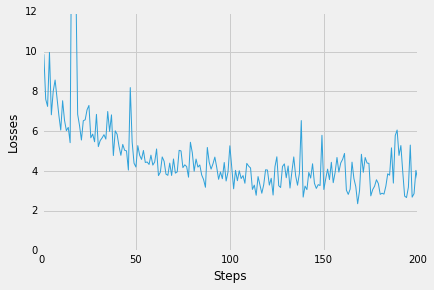

In [ ]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [ ]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ["What' s your name", 'My name is', 'What are you doing', 'I am reading a book',\
                    'How are you', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print '{}.\n--------------------------------'.format(i+1)
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print en_sentences[i]
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print words[i],
            
            print '\n--------------------------------'

1.
--------------------------------
What' s your name
Was ist dein Sohn 
--------------------------------
2.
--------------------------------
My name is
Meine Sohn 
--------------------------------
3.
--------------------------------
What are you doing
Was machst du denn 
--------------------------------
4.
--------------------------------
I am reading a book
Ich bin ein Frühstück 
--------------------------------
5.
--------------------------------
How are you
Wie sind du - 
--------------------------------
6.
--------------------------------
I am good
Ich bin gut 
--------------------------------
7.
--------------------------------
Do you speak English
Weißt du das 
--------------------------------
8.
--------------------------------
What time is it
Was ist denn denn 
--------------------------------
9.
--------------------------------
Hi
Hi 
--------------------------------
10.
--------------------------------
Goodbye
Wiedersehen 
--------------------------------
11.
---------------

# This model can be improved by using more training steps, better dataset or even with better selection of hyperparameters 